# Homework 3

## FINM 36700 - 2023

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu


**IMPORT PACKAGES**

In [389]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import math

**READING DATA**

In [390]:
xls = pd.ExcelFile("/Users/lori/Desktop/barnstable_analysis_data.xlsx")

df = pd.read_excel(xls, 'data', parse_dates=True, index_col=0)
df.fillna(method = 'ffill', inplace=True)
df['Excess_SPY_Returns'] = df['SPX'] - df['TB1M']

In [391]:
df

,SPX,TB1M,Excess_SPY_Returns
date,,,
1926-01-30,-0.001783,0.003061,-0.004844
1926-02-27,-0.033296,0.002612,-0.035908
1926-03-31,-0.057708,0.002601,-0.060309
1926-04-30,0.038522,0.002270,0.036252
1926-05-28,0.013623,0.002691,0.010932
...,...,...,...
2023-04-28,0.015015,0.003475,0.011540
2023-05-31,0.005306,0.004129,0.001178
2023-06-30,0.066952,0.004302,0.062650


# 1. Modeling Volatility and VaR

Use the returns on the S&P 500 ($r^M$) and 1-month T-bills, ($r^f$) provided in "**barnstable analysis data.xlsx**”.

For the full sample of SPY returns, 1926-2023, calculate the LEVEL, (not log,) excess market returns (against the treasury returns.) We use this level excess return data throughout this section.


# 1. Historic VaR.

The historical VaR is estimated directly from data without estimating or assuming any other parameters.

Starting at $t = 61$, calculate the historic-based VaR, based on the expanding sample from period 1 (Jan 1926) to $t − 1$. By historic VaR, we mean simply taking the 5th quantile for the historic sample up to time $t − 1$. Of course, a sample size that is not a multiple of 100 will require some interpolation to get a 5th quantile. Your statistical package should handle this fine.

Denote this as $\tilde{r}^{VaR,.05}_{t,historic}$ , which is the best estimate of the $time-t$ VaR based on data through $t−1$.

**(a) Plot $\tilde{r}^{VaR,.05}_{t,historic}$ over time.**

**(b) Calculate the frequency of periods in which $\tilde{r}^t < \tilde{r}^{VaR,.05}_{t,historic}$**

**(c) What drawbacks do you see in this historic VaR?**

**SOLUTION:**

### Part a:

In [392]:
# expanding from 1 to 60, 1 to 61, 1 to 62....
# each time, sorting the dataset, and then find the 5th obs by: 1(n-1)*p
# and the value is: i+(j-i)*the decimal of 1(n-1)*p
historical_VaR = df['Excess_SPY_Returns'].shift(1).expanding(min_periods = 60).quantile(0.05)

<AxesSubplot:title={'center':'Historic VaR'}, xlabel='date', ylabel='VaR'>

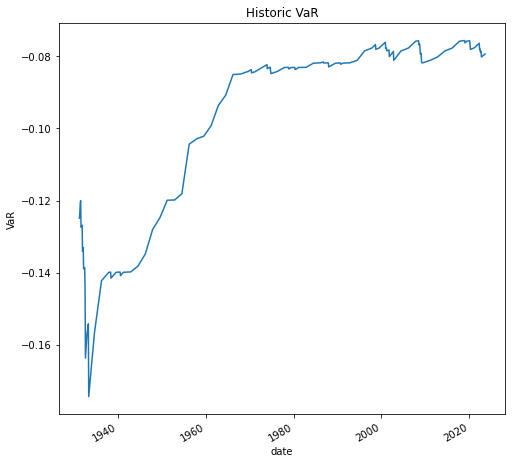

In [393]:
plt.rcParams['figure.figsize'] = [8, 8]

plt.title('Historic VaR')
plt.ylabel('VaR')
plt.xlabel('Date')
historical_VaR.plot()

### Part b:

In [394]:
#freq = []
# for i in range(len(rt)):
#     if rt[i] < non_na[i]:
#         freq.append(1)
#     else:
#         freq.append(0)


In [415]:
rt = df['Excess_SPY_Returns'][60:len(df)+1]
non_na = historical_VaR[60:len(df)+1]

freq = sum(rt<non_na)/len(rt)
print(f'The frequency of the periods is {freq*100}%')

The frequency of the periods is 3.147482014388489%


### Part 3:

The method of historica VaR is completely rely on the historical data, so the information provide for the future market is limited. And the historical VaR just use 5% of the sample.

Also, equal Weights on past observations that may never be relevant again. For example, low returns during 2008 (which may not be relevant anymore) are given the same weight as the most recent observations

# 2. Volatility

We will calculate a time-series of volatility estimates using a few different methods. For each, we use $\sigma_t$ to denote our estimate of the $time-t$ return volatility, as based on data over periods 1 (Jan 1926) through $t − 1$, but not including $t$ itself.

* Expanding Series:
$$\sigma^2_{t,expanding} = \frac{1}{t-1}\Sigma^{t-1}_{\tau=1}\tilde{r}^2_\tau $$

Begin the calculation at $t = 61$, so that the first estimate is based on 60 data points.

* Rolling Window:
$$\sigma^2_{t,rolling} = \frac{1}{m}\Sigma^{m}_{l=1}\tilde{r}^2_{t-l} $$

Use $m = 60$, and begin the calculation at the t = 61, (so that the calculation has a full 60 data points.)

**(a) For each of these three methods, plot $\sigma_t$. (Plot the vol, not the variance.)**

**(b) For each method, calculate the 5th percentile, 1-month-ahead VaR. We use a slight simplification of the normal VaR formula, by dropping $\mu$ from that formula, and rounding the normal distribution z-score to -1.65.**

**(c) For each of these three vol-based VaR estimates, calculate the frequency of periods in which**
$\tilde{r}^t < \tilde{r}^{VaR,.05}_{t,vol}$

**(d) Compare and contrast your results among each other and relative to the historic method in the previous problem.**

### Part a

In [416]:
r_dt = df['Excess_SPY_Returns']

In [417]:
expand_var = ((r_dt**2).shift(1).expanding(min_periods = 60).mean()).dropna()

expand_vol = np.sqrt(expand_var)

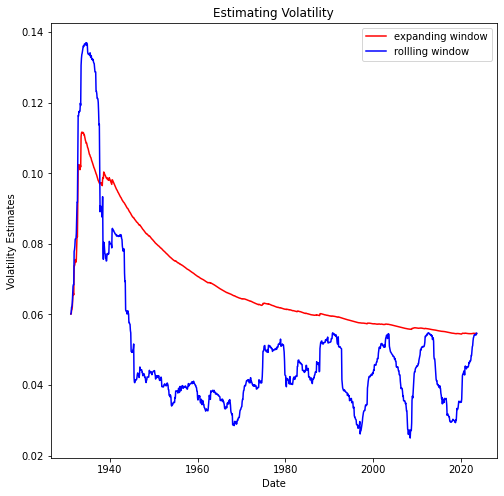

In [418]:
rolling_var = ((r_dt**2).shift(1).rolling(60).mean()).dropna()
rolling_vol = np.sqrt(rolling_var)

plt.title('Estimating Volatility')
plt.ylabel('Volatility Estimates')
plt.xlabel('Date')
plt.plot(expand_vol,'r')
plt.plot(rolling_vol,'b')
plt.legend(['expanding window', 'rollling window'])

### Part b:

In [419]:
#Using normal distribution
zscore = -1.65
expand_fifth = zscore*expand_vol
rolling_fifth = zscore*rolling_vol

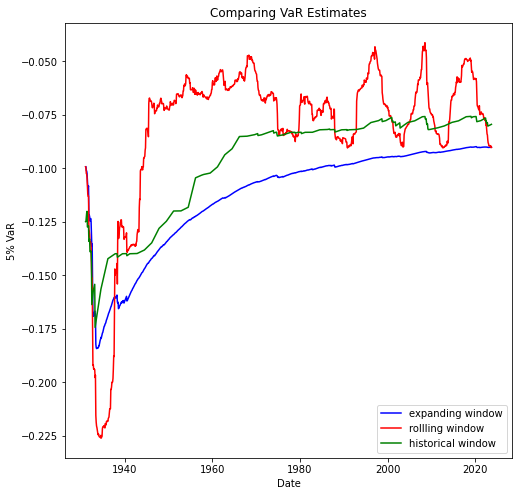

In [420]:
plt.title('Comparing VaR Estimates')
plt.ylabel('5% VaR')
plt.xlabel('Date')
plt.plot(expand_fifth,'b')
plt.plot(rolling_fifth,'r')
plt.plot(historical_VaR,'g')
plt.legend(['expanding window', 'rollling window', 'historical window'])

### Part c:

In [421]:
expand_period = sum(rt < expand_fifth)/len(expand_fifth)
print(f'The frequency of expanding window is {expand_period*100}%')

The frequency of expanding window is 1.7985611510791366%


In [422]:
rolling_period = sum(rt < rolling_fifth)/len(rolling_fifth)
print(f'The frequency of rolling window is {rolling_period*100}%')

The frequency of rolling window is 4.946043165467626%


### Part d:

From previous part we know the frequency of historic VaR is about 3.15%. Therefore, rolling window has higher volatility than other medthods since it place more weight on the most recent observations.

# 3. CVar

Re-do the previous two problems, but this time calculating CVaR instead of VaR, (still for q = .05.) That is, calculate CVaR for

* the empirical cdf
* the normal model, using expanding volatility estimates 
* the normal model, using rolling volatility estimates

### (a)

In [407]:
cdf_emp = []
for i in range(len(rt)):
    expds = df['Excess_SPY_Returns'][0:i+60].sort_values()
    cdf_emp.append(expds[(expds <= historical_VaR[i+60])].mean())
    
emp_df = pd.DataFrame(cdf_emp, columns = ['the_emperical_cdf'], index = rt.index)

In [408]:
q = 0.05
scaling = -(norm.pdf(-zscore)/q)
rolling_CVaR = scaling*rolling_vol
expand_CVaR = scaling*expand_vol

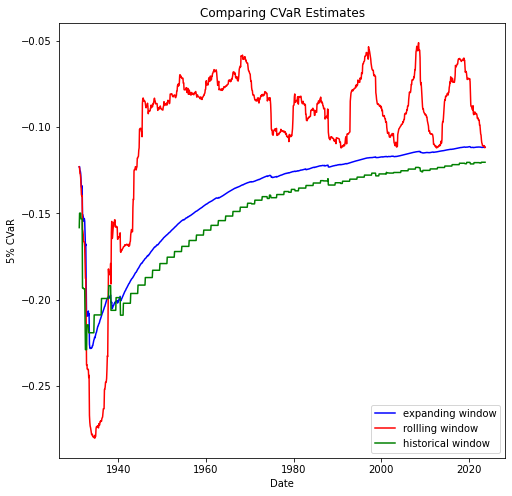

In [409]:
plt.plot(expand_CVaR ,'b')
plt.plot(rolling_CVaR,'r')
plt.plot(emp_df,'g')
plt.title('Comparing CVaR Estimates')
plt.ylabel('5% CVaR')
plt.xlabel('Date')
plt.legend(['expanding window', 'rollling window', 'historical window'])

### (b)

In [412]:
expandCVaR_period = sum(rt < expand_CVaR)/len(expand_CVaR)
print(f'The frequency of expanding window is {expandCVaR_period*100}%')

The frequency of expanding window is 0.8992805755395683%


In [413]:
rollingCVaR_period = sum(rt < rolling_CVaR)/len(rolling_CVaR)
print(f'The frequency of rolling window is {rollingCVaR_period*100}%')

The frequency of rolling window is 2.877697841726619%


# 3: Estimating Underperformance

### Part a:

In [328]:
stats_table = pd.DataFrame(
            index = pd.MultiIndex.from_tuples([('levels', 'SPX'),('levels', 'RiskFree'),('levels', 'Excess SPX'),
                                              ('logs', 'SPX'),('logs', 'RiskFree'), ('logs', 'Excess SPX')]),
            columns = pd.MultiIndex.from_tuples([('1965-1999','mean'),('1965-1999','vol'),
                                                ('2000-2023','mean'),('2000-2023','vol'),
                                                ('1926-2023','mean'),('1926-2023','vol')]))

stats_table[('1965-1999','mean')] = list(np.mean(df.loc['1965':'1999']) * 12) + list(np.mean(np.log(1+df.loc['1965':'1999']))*12)
stats_table[('1965-1999','vol')] = list(np.std(df.loc['1965':'1999']) * np.sqrt(12)) + list(np.std(np.log(1+df.loc['1965':'1999'])) * np.sqrt(12))
stats_table[('2000-2023','mean')] = list(np.mean(df.loc['2000':'2023']) * 12) + list(np.mean(np.log(1+df.loc['2000':'2023']))*12)
stats_table[('2000-2023','vol')] = list(np.std(df.loc['2000':'2023']) * np.sqrt(12)) + list(np.std(np.log(1+df.loc['2000':'2023'])) * np.sqrt(12))
stats_table[('1926-2023','mean')] = list(np.mean(df) * 12) + list(np.mean(np.log(1+df))*12)
stats_table[('1926-2023','vol')] = list(np.std(df) * np.sqrt(12)) + list(np.std(np.log(1+df)) * np.sqrt(12))

display(stats_table.style.format('{:,.1%}'))

### Part b:

R_m-R_f = R_delta_M, use excess return directly. P(R_delta_M < 0), zscore = 0-mu/sigma
and the log return is linear, so just times sqrt(h).

In [329]:
def prob(mu, sigma, h):
    return norm.cdf(-np.sqrt(h)*mu/sigma)

mu = stats_table[('1965-1999', 'mean')][('logs', 'Excess SPX')]
sigma = stats_table[('1965-1999', 'vol')][('logs', 'Excess SPX')]

print('Probability of SPX underperforming RF in the next 15 years after 1999: {:,.1%}'.
      format(prob(mu = mu, sigma = sigma, h = 15)))

print('Probability of SPX underperforming RF in the next 30 years after 1999: {:,.1%}'.
      format(prob(mu = mu, sigma = sigma, h = 30)))

Probability of SPX underperforming RF in the next 15 years after 1999: 7.4%
Probability of SPX underperforming RF in the next 30 years after 1999: 2.0%


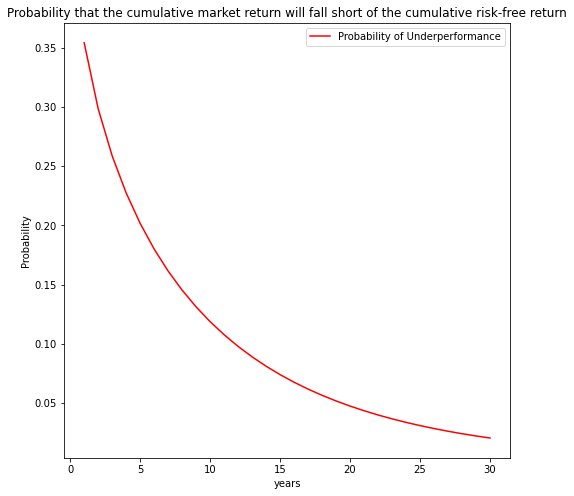

In [342]:
h = list(range(1, 31))
probs = pd.DataFrame([prob(mu, sigma, x) for x in h], columns=['Probability of Underperformance'], index = h)
probs.plot(color = 'red')
plt.title('Probability that the cumulative market return will fall short of the cumulative risk-free return')
plt.ylabel('Probability')
plt.xlabel('years')
plt.show()